In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from baukit import TraceDict

# Download the modelz
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# set seed
torch.manual_seed(0)
np.random.seed(0)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
layers = model.config.num_hidden_layers
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.attention") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
num_layers = len(cache_names)
cache_names = [item for sublist in cache_names for item in sublist]
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)

In [3]:
from activation_dataset import chunk_and_tokenize
# Download the dataset
# This formats it, so every datapoint is max_length tokens long
# The batch size is for loading activations from the LLM, not for inference on the autoencoder
dataset_name="stas/openwebtext-10k"
max_seq_length=256
dataset = load_dataset(dataset_name, split="train")
dataset, _ = chunk_and_tokenize(dataset, tokenizer, max_length=max_seq_length)
max_tokens = dataset.num_rows*max_seq_length
print(f"Number of tokens: {max_tokens/1e6:.2f}M")

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-89f7d956ed9de0f6_*_of_00008.arrow


Number of tokens: 11.23M


In [4]:
# split dataset into both a train & test set
test_size = 0.1
test_size = int(len(dataset)*test_size)
train_size = len(dataset)-test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"Number of Train Tokens: {len(train_dataset)*max_seq_length/1e6:.2f}M")
print(f"Number of Test Tokens: {len(test_dataset)*max_seq_length/1e6:.2f}M")

Number of Train Tokens: 10.10M
Number of Test Tokens: 1.12M


In [5]:
# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [6]:
from torch.optim import Adam
from torch import nn
    
class mlp(nn.Module):
    def __init__(self, input_size, output_size=None, hidden_size=None, bias=True):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        if(hidden_size is None):
            hidden_size = input_size
        # Only adding a bias to the latent layer
        self.linear = nn.Linear(input_size, hidden_size, bias=bias)
        self.linear2 = nn.Linear(hidden_size, output_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    def latent(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x
    
class linear(nn.Module):
    def __init__(self, input_size, output_size=None, bias=True):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, output_size, bias=bias)
    def forward(self, x):
        x = self.linear(x)
        return x

In [7]:
# Load in the features indices
# Note: linear & MLP features are a subet of alive features, not total features
import pickle
with open("linear_features.pkl", "rb") as f:
    linear_features = pickle.load(f)
with open("mlp_features.pkl", "rb") as f:
    mlp_features = pickle.load(f)
with open("alive_features.pkl", "rb") as f:
    alive_features_ind = pickle.load(f)
normalization_per_layer = torch.load("normalization_per_layer.pt")

In [8]:
num_features, d_model = autoencoder.encoder.shape

mlp_weights = []
mlp_optimizers = []
for auto_ind in range(num_layers):
    mlp_weights.append(mlp(num_features, bias=False))
    mlp_weights[-1].to(device)
    mlp_optimizers.append(Adam(mlp_weights[-1].parameters(), lr=1e-3))

In [9]:
from baukit import TraceDict, Trace
from torch.nn import functional as F
def replace_with_reconstructed_features(mlp_out, layer_name, reconstruction):
    # We will have the true activations at MLP_out, & the reconstruction. 
    return reconstruction

def replace_with_sae(mlp_out, layer_name, autoencoder):
    b, s, n = mlp_out.shape
    mlp_flattened = rearrange(mlp_out, "b s n -> (b s) n")
    reconstruction_flattened = autoencoder.predict(mlp_flattened)
    reconstruction = rearrange(reconstruction_flattened, "(b s) n -> b s n", b=b, s=s)
    return reconstruction

def ablate_activations(mlp_out, layer_name):
    return torch.zeros_like(mlp_out)

def cross_entropy(logits, tokens):
    # Print amount in gpu
    #Ripped from transformer lens library
    log_probs = F.log_softmax(logits, dim=-1)

    # Use torch.gather to find the log probs of the correct tokens
    # Offsets needed because we're predicting the NEXT token (this means the final logit is meaningless)
    # None and [..., 0] needed because the tensor used in gather must have the same rank.
    predicted_log_probs = log_probs[..., :-1, :].gather(
        dim=-1, index=tokens[..., 1:, None]
    )[..., 0]
    return -predicted_log_probs.mean()

# Overall we need:
# - 1. Original loss (1 dashed line)
# - 1.5. SAE reconstruction loss ([layer] dashed lines)
# - 2. Sparse Weight Reconstruction loss ([layer] lines) (MSE vs CE for x,y)
# - 3. zero ablated loss ([layer] dashed lines)
# We get original by default, so no special settings needed
def calculate_cross_entropy_loss(model, setting, sparse_weights, dataset, autoencoders, cache_names, max_batches):
    device = model.device
    settings = ["sae", "sparse_weights", "ablate", "original"]
    setting_ind = settings.index(setting)
    intervention_functions = [replace_with_sae, replace_with_reconstructed_features, ablate_activations, None]
    intervention_function = intervention_functions[setting_ind]

    assert max_batches < len(dataset)
    reconstructed_loss = [0]*num_layers
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            if(setting == "sae" or setting == "ablate"):
                for cache_name_ind in range(num_layers):
                    output_cache_name = cache_names[cache_name_ind * 2 + 1]
                    output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                    if(setting=="sae"):
                        intervention_function = partial(replace_with_sae,  autoencoder=output_autoencoder)
                    else:
                        intervention_function = partial(ablate_activations)
                    with Trace(model, output_cache_name, edit_output=intervention_function) as _:
                        logits = model(batch).logits
                    recon_loss = cross_entropy(logits, batch).item()
                    reconstructed_loss[cache_name_ind] += recon_loss
                    # divide_by = i + 1
                    # print(f"Layer:{cache_name_ind+1} Reconstructed Loss: {reconstructed_loss[cache_name_ind]/divide_by:.2f} ")
            elif(setting == "original"):
                logits = model(batch).logits
                reconstructed_loss[0] += cross_entropy(logits, batch).item()
            elif(setting == "sparse_weights"):
                with TraceDict(model, cache_names) as ret:
                    _ = model(batch).logits
                for cache_name_ind in range(num_layers):
                    input_cache_name = cache_names[cache_name_ind * 2]
                    input_autoencoder = autoencoders[cache_name_ind * 2]
                    input_activations = ret[input_cache_name].output
                    if isinstance(input_activations, tuple):
                        input_activations = input_activations[0]
                    input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                    input_internal_activations = input_autoencoder.encode(input_internal_activations)
                    x_hat = sparse_weights[cache_name_ind](input_internal_activations)
                    # Decode x_hat
                    output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                    x_hat = output_autoencoder.decode(x_hat)
                    # Rearrange x_hat back to b s n
                    x_hat = rearrange(x_hat, "(b s) n -> b s n", b=batch.shape[0], s=batch.shape[1])
                    # replace the activations with the reconstructed activations
                    output_cache_name = cache_names[cache_name_ind * 2 + 1]
                    intervention_function = partial(replace_with_reconstructed_features,  reconstruction=x_hat)
                    with Trace(model, output_cache_name, edit_output=intervention_function) as _:
                        logits = model(batch).logits
                    # Calculate loss
                    recon_loss = cross_entropy(logits, batch).item()
                    reconstructed_loss[cache_name_ind] += recon_loss
                    
                    del logits
                    torch.cuda.empty_cache()
                del ret, input_activations, input_internal_activations, x_hat
                torch.cuda.empty_cache()
                    # divide_by = i + 1
                    # print(f"Layer:{cache_name_ind+1} | Original Loss: {original_loss[cache_name_ind]/divide_by:.2f} | Reconstructed Loss: {reconstructed_loss[cache_name_ind]/divide_by:.2f} | Difference: {loss_diff[cache_name_ind]/divide_by:.2f}")
        if(i > max_batches):
            break
    # Average
    try:
        del batch, logits
        torch.cuda.empty_cache()
    except:
        pass
    reconstructed_loss = [rec_loss/max_batches for rec_loss in reconstructed_loss]
    return reconstructed_loss

In [10]:
# max_batches = 100
# sae_loss= calculate_cross_entropy_loss(model, "sae", mlp_weights, test_dataloader, autoencoders, cache_names, max_batches)
# # ablated_loss= calculate_cross_entropy_loss(model, "ablate", mlp_weights, test_dataloader, autoencoders, cache_names, max_batches)
# # original_loss = calculate_cross_entropy_loss(model, "original", mlp_weights, test_dataloader, autoencoders, cache_names, max_batches)
# # sparse_loss = calculate_cross_entropy_loss(model, "sparse_weights", mlp_weights, test_dataloader, autoencoders, cache_names, max_batches)
# print(f"SAE Loss: {np.array(sae_loss).round(2)}")
# # print(f"Ablated Loss: {np.array(ablated_loss).round(2)}")
# # print(f"Original Loss: {np.array(original_loss).round(2)}")
# # print(f"Sparse Loss: {np.array(sparse_loss).round(2)}"), sparse_loss

 73%|███████▎  | 101/138 [01:58<00:43,  1.17s/it]

SAE Loss: [5.2  5.21 5.24 5.25 5.34]


In [26]:
def train_sparse_model_and_check_CE(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, test_dataloader):
    mse = nn.MSELoss()
    losses = [[] for _ in range(len(sparse_weights))]
    max_batches_for_ce = 100
    max_training_batches = 1024
    check_ce_every = [0] + [2**ch for ch in range(int(np.log2(max_training_batches))+1)]
    ce_losses = np.zeros((num_layers, len(check_ce_every)))
    current_mse_losses = np.zeros((num_layers, len(check_ce_every)))

    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            x_hat = sparse_weights[cache_name_ind](input_internal_activations)

            # loss = mse(x_hat, output_internal_activations)
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
            indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind.to(device))
            indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind.to(device))
            loss = mse(indexed_x_hat, indexed_output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha * l1_loss

            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind].append(loss.item())
            if i in check_ce_every:
                print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")
        if i in check_ce_every:
            index = check_ce_every.index(i)
            ce_losses[:, index] = calculate_cross_entropy_loss(model, "sparse_weights", mlp_weights, test_dataloader, autoencoders, cache_names, max_batches_for_ce)
            # for losses_layer in losses:
            #     current_mse_losses[:, index] = losses_layer[-1]
            # change above to enumerate
            for loss_ind, losses_layer in enumerate(losses):
                current_mse_losses[loss_ind, index] = losses_layer[-1]
        if i > max_training_batches:
            # Stop training after 1000 batches
            break
    return losses, ce_losses, current_mse_losses

mlp_losses, ce_losses, current_mse_losses = train_sparse_model_and_check_CE(model, train_dataloader, device, mlp_weights, autoencoders, cache_names, mlp_optimizers, test_dataloader)

  0%|          | 0/1234 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.0035245150793343782 | L1 Loss: 26.32503318786621
Layers: 1 | MSE Loss: 0.04229045286774635 | L1 Loss: 27.799665451049805
Layers: 2 | MSE Loss: 0.011477219872176647 | L1 Loss: 28.413433074951172
Layers: 3 | MSE Loss: 0.02035048045217991 | L1 Loss: 28.71422576904297
Layers: 4 | MSE Loss: 2.411552667617798 | L1 Loss: 32.78802490234375


  0%|          | 1/1234 [00:41<14:20:14, 41.86s/it]

Failed to delete batch
Layers: 0 | MSE Loss: 0.0034442057367414236 | L1 Loss: 26.300086975097656
Layers: 1 | MSE Loss: 0.038861971348524094 | L1 Loss: 27.912710189819336
Layers: 2 | MSE Loss: 0.010576254688203335 | L1 Loss: 28.5341854095459
Layers: 3 | MSE Loss: 0.01786251924932003 | L1 Loss: 28.844968795776367
Layers: 4 | MSE Loss: 2.3519036769866943 | L1 Loss: 33.5914306640625


  0%|          | 2/1234 [01:22<14:00:36, 40.94s/it]

Failed to delete batch
Layers: 0 | MSE Loss: 0.003487267764285207 | L1 Loss: 26.283554077148438
Layers: 1 | MSE Loss: 0.03541006147861481 | L1 Loss: 28.042861938476562
Layers: 2 | MSE Loss: 0.01059369370341301 | L1 Loss: 28.65511703491211
Layers: 3 | MSE Loss: 0.017537061125040054 | L1 Loss: 28.97562026977539
Layers: 4 | MSE Loss: 2.197608470916748 | L1 Loss: 34.45584487915039


  0%|          | 3/1234 [02:02<13:54:51, 40.69s/it]

Failed to delete batch


  0%|          | 4/1234 [02:03<8:33:20, 25.04s/it] 

Layers: 0 | MSE Loss: 0.0030550076626241207 | L1 Loss: 26.283851623535156
Layers: 1 | MSE Loss: 0.03115616925060749 | L1 Loss: 28.354595184326172
Layers: 2 | MSE Loss: 0.009423179551959038 | L1 Loss: 28.885610580444336
Layers: 3 | MSE Loss: 0.016455650329589844 | L1 Loss: 29.23208999633789
Layers: 4 | MSE Loss: 1.8405691385269165 | L1 Loss: 36.36079406738281


  0%|          | 5/1234 [02:44<10:31:58, 30.85s/it]

Failed to delete batch


  1%|          | 8/1234 [02:47<3:26:07, 10.09s/it] 

Layers: 0 | MSE Loss: 0.003020644187927246 | L1 Loss: 26.418455123901367
Layers: 1 | MSE Loss: 0.022153012454509735 | L1 Loss: 29.25360679626465
Layers: 2 | MSE Loss: 0.008525079116225243 | L1 Loss: 29.3341121673584
Layers: 3 | MSE Loss: 0.013160641305148602 | L1 Loss: 29.740371704101562
Layers: 4 | MSE Loss: 1.2306838035583496 | L1 Loss: 40.83501052856445


  1%|          | 9/1234 [03:30<6:51:22, 20.15s/it]

Failed to delete batch


  1%|▏         | 16/1234 [03:37<52:29,  2.59s/it]  

Layers: 0 | MSE Loss: 0.0024454055819660425 | L1 Loss: 26.963470458984375
Layers: 1 | MSE Loss: 0.009690405800938606 | L1 Loss: 31.544729232788086
Layers: 2 | MSE Loss: 0.00683040264993906 | L1 Loss: 30.22693634033203
Layers: 3 | MSE Loss: 0.010060451924800873 | L1 Loss: 30.835769653320312
Layers: 4 | MSE Loss: 0.46292397379875183 | L1 Loss: 49.55202865600586


  1%|▏         | 17/1234 [04:20<4:57:46, 14.68s/it]

Failed to delete batch


  3%|▎         | 32/1234 [04:36<22:58,  1.15s/it]  

Layers: 0 | MSE Loss: 0.0018937926506623626 | L1 Loss: 28.143077850341797
Layers: 1 | MSE Loss: 0.006358506623655558 | L1 Loss: 35.425045013427734
Layers: 2 | MSE Loss: 0.0053616599179804325 | L1 Loss: 31.937862396240234
Layers: 3 | MSE Loss: 0.00788881815969944 | L1 Loss: 32.86241912841797
Layers: 4 | MSE Loss: 0.2462477684020996 | L1 Loss: 52.636207580566406


  3%|▎         | 33/1234 [05:19<4:35:16, 13.75s/it]

Failed to delete batch


  3%|▎         | 33/1234 [05:21<3:14:44,  9.73s/it]


In [13]:
sae_loss = [5.2, 5.21, 5.24, 5.25, 5.34]
ablated_loss = [5.76, 5.56, 5.84, 5.97, 8.34]
original_loss = [4.97, 0.0, 0.0, 0.0, 0.0]
ce_losses.shape [5, 32]
current_mse_losses.shape [5, 32]

(array([[17.51402569, 17.83579779, 17.92674923, 16.55920839, 17.24656582],
        [16.76214933, 17.1236558 , 17.09464455, 15.90950537, 16.49893951],
        [18.79931641, 17.43049192, 17.38503742, 16.18795967, 17.30828142],
        [17.89380693, 17.79901743, 17.75995731, 16.63832045, 17.34812117],
        [26.28217793, 23.92018318, 23.79368687, 22.53576088, 23.34414482]]),
 array([[3.35471964, 3.30281377, 3.2831161 , 3.00685072, 2.6922009 ],
        [3.35471964, 3.30281377, 3.2831161 , 3.00685072, 2.6922009 ],
        [3.35471964, 3.30281377, 3.2831161 , 3.00685072, 2.6922009 ],
        [3.35471964, 3.30281377, 3.2831161 , 3.00685072, 2.6922009 ],
        [3.35471964, 3.30281377, 3.2831161 , 3.00685072, 2.6922009 ]]))

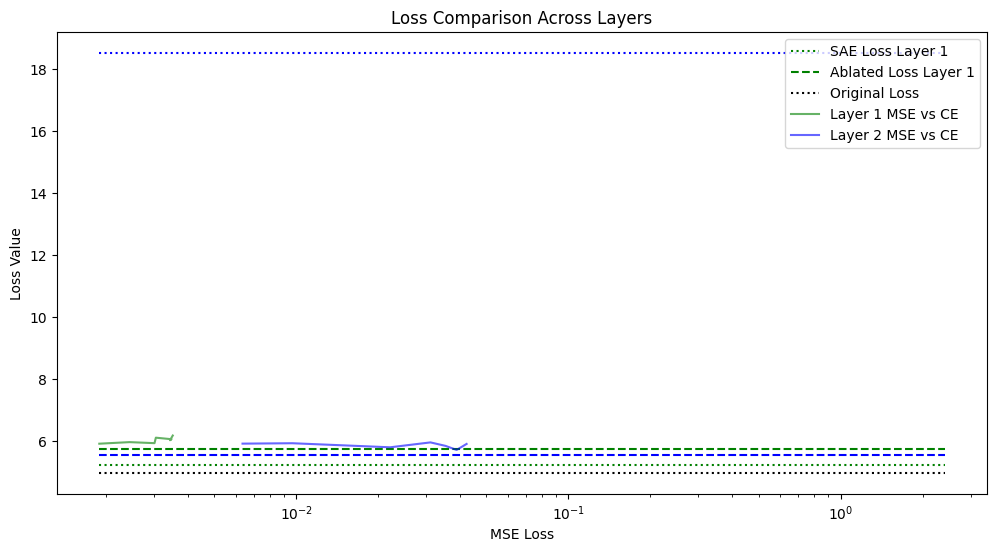

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Data
sae_loss = [5.22, 18.51, 24.61, 28.82, 31.18]
ablated_loss = [5.76, 5.56, 5.84, 5.97, 8.34]
original_loss = [4.97, 0.0, 0.0, 0.0, 0.0]

# Simulated data for ce_losses and current_mse_losses
# Replace these with your actual data

# Colors for each set of lines
colors = ['green', 'blue', 'red', 'purple', 'orange']
# Adjusting the plot to have horizontal lines and setting x-positions based on current_mse_losses

plt.figure(figsize=(12, 6))
# plot_num_layers = num_layers
plot_num_layers = 2
# Plot SAE, Ablated, and Original Loss
min_mse = np.min(current_mse_losses)
max_mse = np.max(current_mse_losses)
for i in range(plot_num_layers):
    # Find min and max values for current MSE losses for each layer

    # Plot horizontal lines for SAE and Ablated Loss
    plt.hlines(sae_loss[i], xmin=min_mse, xmax=max_mse, linestyle=':', color=colors[i], label=f'SAE Loss Layer {i+1}' if i==0 else '')
    plt.hlines(ablated_loss[i], xmin=min_mse, xmax=max_mse, linestyle='--', color=colors[i], label=f'Ablated Loss Layer {i+1}' if i==0 else '')

# Plot Original Loss (only first entry)
plt.hlines(original_loss[0], xmin=np.min(current_mse_losses), xmax=np.max(current_mse_losses), linestyle=':', color='black', label='Original Loss')

# Plot CE Losses vs MSE Losses
for i in range(plot_num_layers):
    plt.plot(current_mse_losses[i], ce_losses[i], linestyle='-', color=colors[i], alpha=0.6, label=f'Layer {i+1} MSE vs CE')

plt.xlabel('MSE Loss')
plt.ylabel('Loss Value')
plt.title('Loss Comparison Across Layers')
# put x on logscale
plt.xscale('log')
plt.legend()
plt.show()

In [35]:
current_mse_losses.min(), ce_losses

(0.0018937926506623626,
 array([[6.18211966, 6.02914603, 6.06314085, 6.11263404, 5.93586223,
         5.96935236, 5.91859512],
        [5.9111654 , 5.71812823, 5.84754496, 5.96049926, 5.80268402,
         5.93351719, 5.92058692],
        [6.12032082, 5.91634316, 6.62616775, 6.46899774, 6.77417388,
         6.09019868, 6.08603463],
        [6.176105  , 6.03067589, 6.28820269, 6.33069973, 6.14223993,
         6.13182864, 6.09218993],
        [8.12382634, 7.91630123, 8.8269937 , 8.43445196, 9.0053581 ,
         7.81682587, 7.65184128]]))

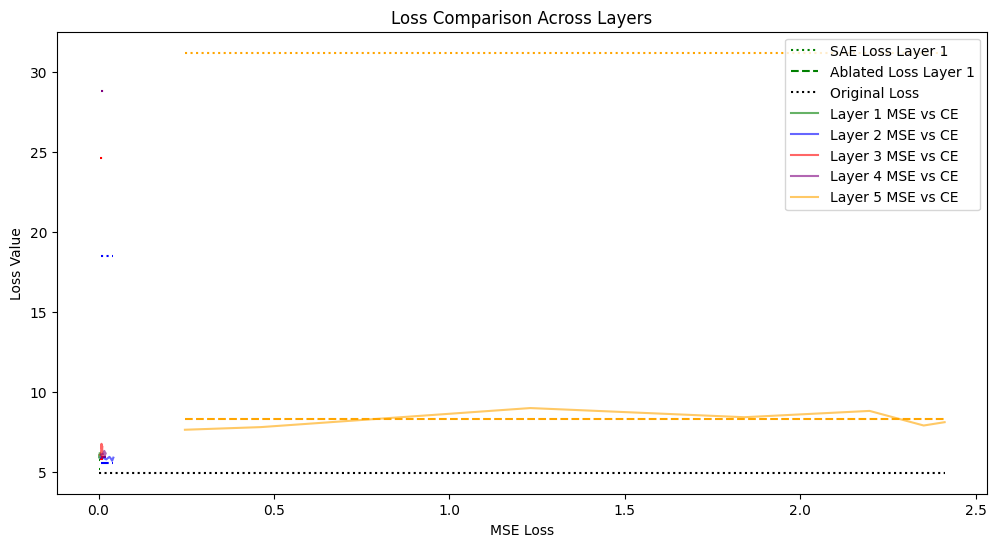

In [28]:
# Adjusting the plot to have horizontal lines and setting x-positions based on current_mse_losses

plt.figure(figsize=(12, 6))

# Plot SAE, Ablated, and Original Loss
for i in range(5):
    # Find min and max values for current MSE losses for each layer
    min_mse = np.min(current_mse_losses[i])
    max_mse = np.max(current_mse_losses[i])

    # Plot horizontal lines for SAE and Ablated Loss
    plt.hlines(sae_loss[i], xmin=min_mse, xmax=max_mse, linestyle=':', color=colors[i], label=f'SAE Loss Layer {i+1}' if i==0 else '')
    plt.hlines(ablated_loss[i], xmin=min_mse, xmax=max_mse, linestyle='--', color=colors[i], label=f'Ablated Loss Layer {i+1}' if i==0 else '')

# Plot Original Loss (only first entry)
plt.hlines(original_loss[0], xmin=np.min(current_mse_losses), xmax=np.max(current_mse_losses), linestyle=':', color='black', label='Original Loss')

# Plot CE Losses vs MSE Losses
for i in range(5):
    plt.plot(current_mse_losses[i], ce_losses[i], linestyle='-', color=colors[i], alpha=0.6, label=f'Layer {i+1} MSE vs CE')

plt.xlabel('MSE Loss')
plt.ylabel('Loss Value')
plt.title('Loss Comparison Across Layers')
plt.legend()
plt.show()


NameError: name 'current_mse_losses' is not defined

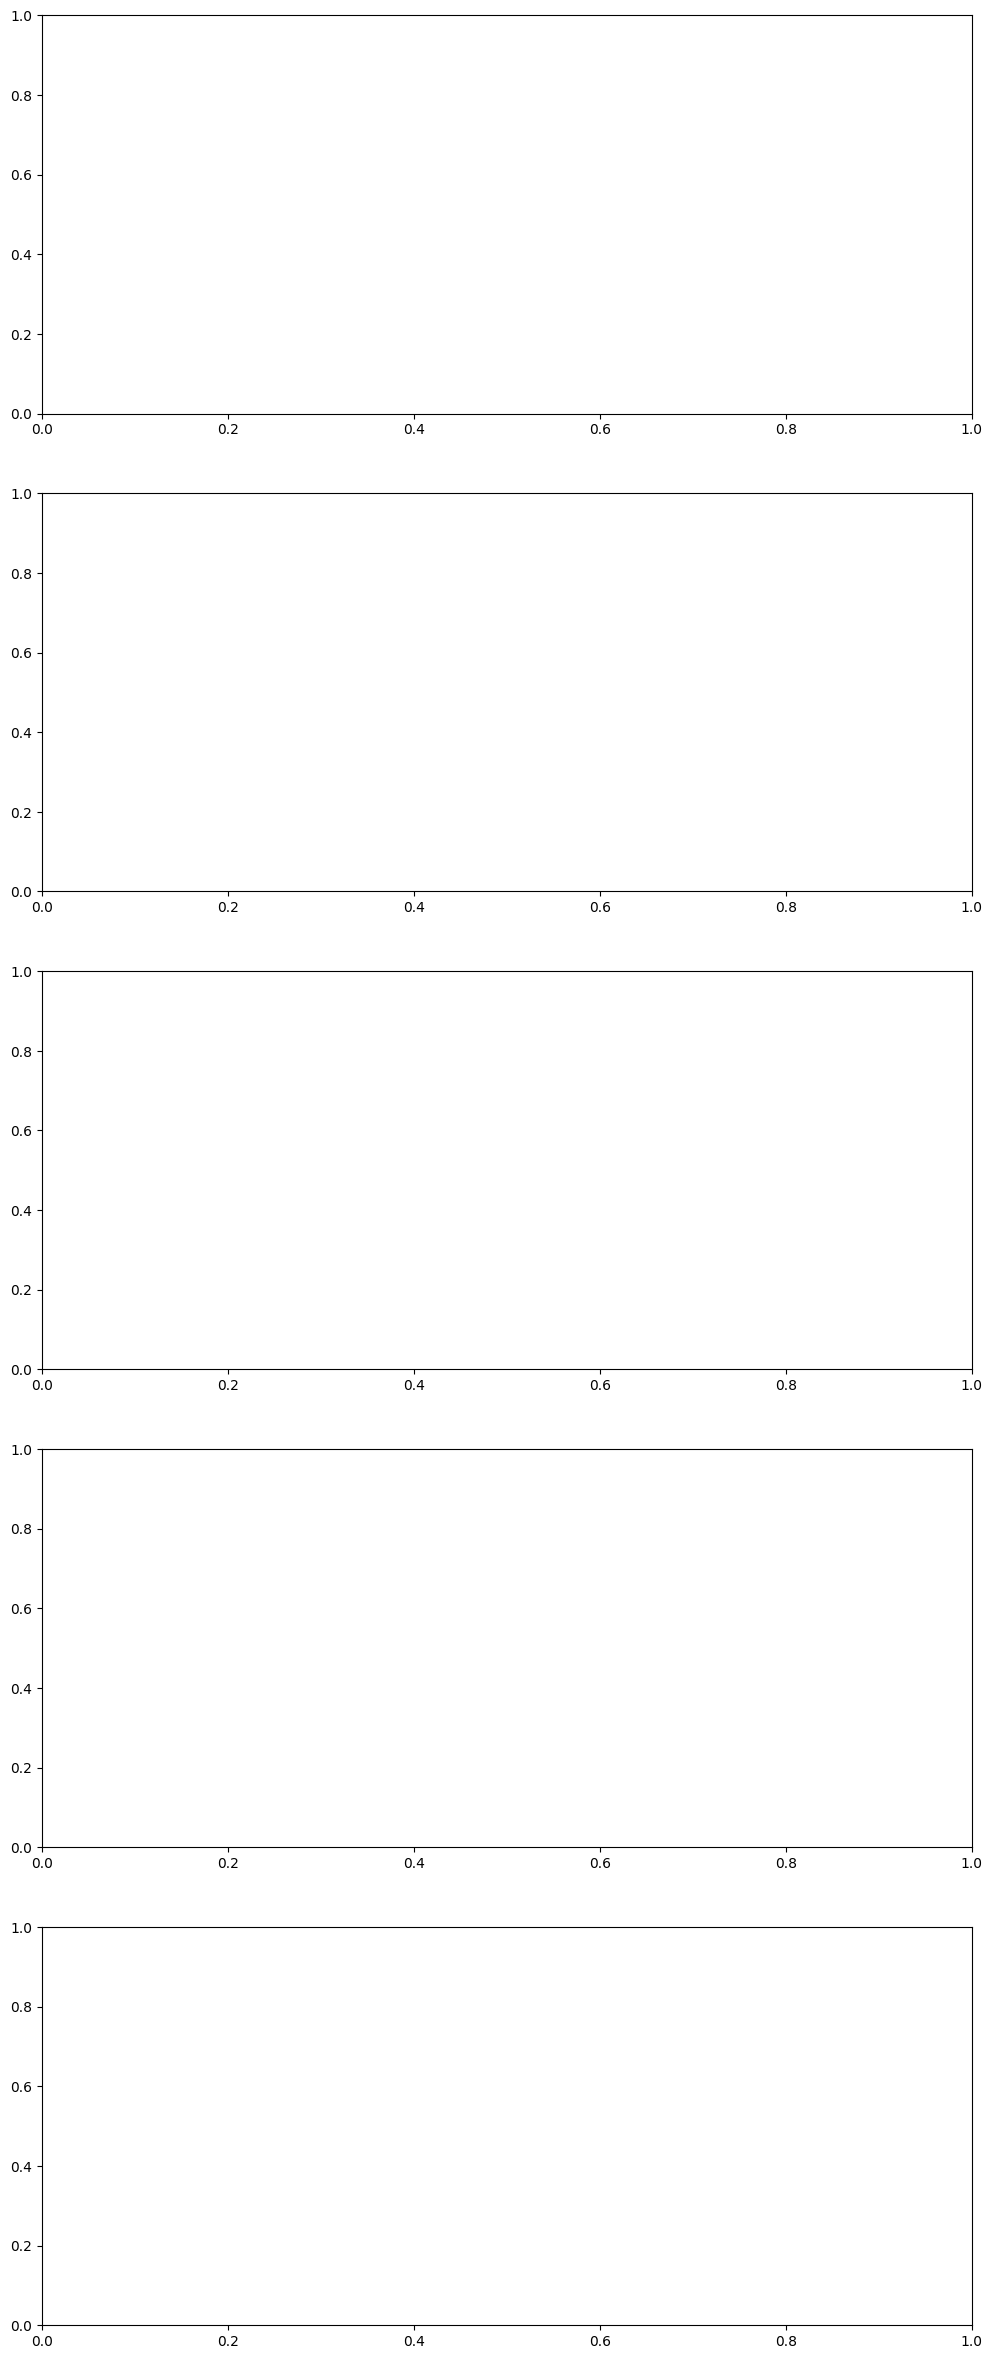

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data
sae_loss = [5.22, 18.51, 24.61, 28.82, 31.18]
ablated_loss = [5.76, 5.56, 5.84, 5.97, 8.34]
original_loss = [4.97, 0.0, 0.0, 0.0, 0.0]

# Simulated data for ce_losses and current_mse_losses
# Replace these with your actual data

# Colors for each set of lines
colors = ['green', 'blue', 'red', 'purple', 'orange']
# Adjusting the plot to have horizontal lines and setting x-positions based on current_mse_losses

# Adjusting the subplots to have independent x-axes for each layer

fig, axes = plt.subplots(num_layers, 1, figsize=(12, 6 * num_layers))

for i in range(num_layers):
    ax = axes[i]

    # Plot horizontal lines for SAE and Ablated Loss
    ax.hlines(sae_loss[i], xmin=np.min(current_mse_losses[i]), xmax=np.max(current_mse_losses[i]), linestyle=':', color=colors[i], label='SAE Loss')
    ax.hlines(ablated_loss[i], xmin=np.min(current_mse_losses[i]), xmax=np.max(current_mse_losses[i]), linestyle='--', color=colors[i], label='Ablated Loss')
    
    # Plot Original Loss
    ax.hlines(original_loss[0], xmin=np.min(current_mse_losses[i]), xmax=np.max(current_mse_losses[i]), linestyle=':', color='black', label='Original Loss')

    # Plot CE Losses vs MSE Losses
    ax.plot(current_mse_losses[i], ce_losses[i], linestyle='-', color=colors[i], alpha=0.6, label='MSE vs CE')

    ax.set_ylabel('CE Loss')
    ax.set_title(f'Layer {i+1}')
    ax.legend()

plt.xlabel('MSE Loss (F2 - MLP(F1))')
plt.suptitle('Loss Comparison Across Layers')
plt.show()
